# 利用VGG19对CIFAR10数据集进行分类

### VGG19起源与介绍
VGGNet是牛津大学计算机视觉组（Visual Geometry Group）和Google DeepMind公司的研究员一起研发的卷积神经网络。VGGNet探索了卷积神经网络的深度与其性能之间的关系，通过反复的使用$3\times3$的小型卷积核和$2\times2$的最大池化层，VGGNet成功地构筑了16～19层深的卷积神经网络。
如图所示，即为VGG19的网络结构：

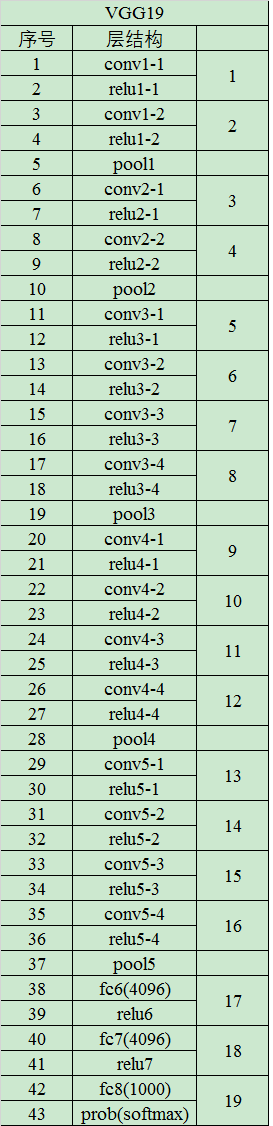

### VGG16与VGG19的直观对比
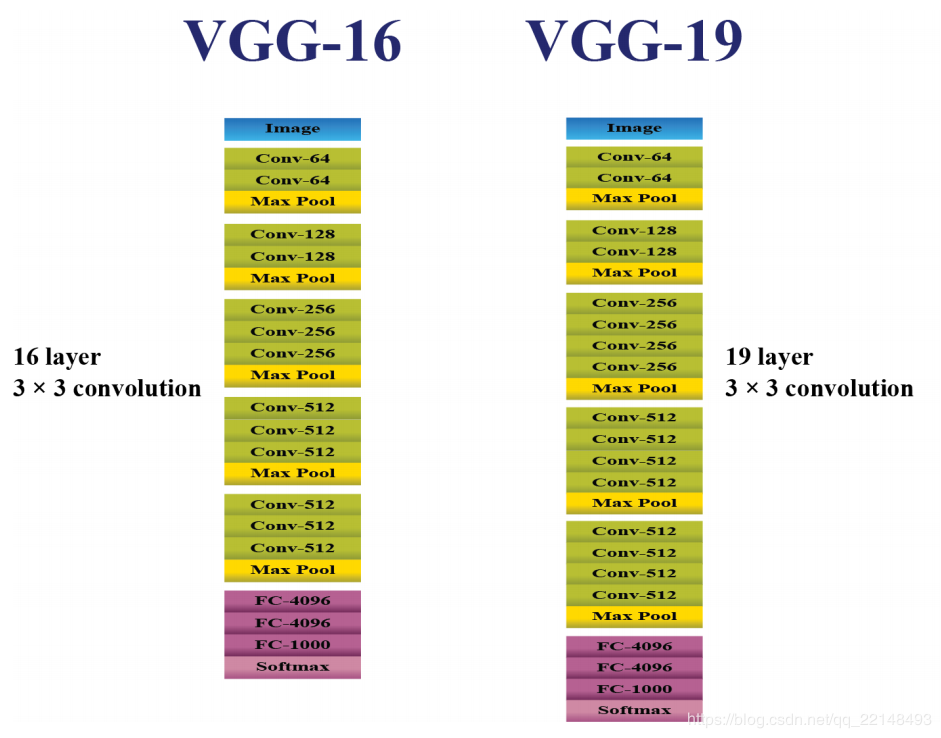

### 预准备
在搭建VGG19网络结构之前，首先做预准备，包括：
+ 1.导入必要的库
+ 2.CIFAR10数据集的预处理
+ 3.定义训练模型用的辅助函数

In [1]:
# 1.导入必要的库
import torch
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as trans
import time

In [2]:
# 超参数
BATCH_SIZE = 128
nepochs = 300
LR = 0.001

# 定义损失函数为交叉熵损失 loss_func
loss_func = nn.CrossEntropyLoss()

# 可以在GPU或者CPU上运行
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# 2.CIFAR10数据集的预处理

# CIFAR10的输入图片各channel的均值 mean 和标准差 std 
mean = [x/255 for x in [125.3, 23.0, 113.9]] 
std = [x/255 for x in [63.0, 62.1, 66.7]]
n_train_samples = 50000

# 如果是多进程需要加一个main函数，否则会报错
if __name__ == '__main__':
    
    # 数据增强-->训练集
    train_set = dsets.CIFAR10(root='./data',  # 数据集保存路径
                              train=True,
                              download=False,   # 如果未下载，改为True；如果已经下载好，改为False
                              transform=trans.Compose([
                                 trans.RandomHorizontalFlip(),
                                 trans.RandomCrop(32, padding=4),
                                 trans.ToTensor(),
                                 trans.Normalize(mean, std)
                             ]))
    train_dl = DataLoader(train_set,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=6)        # 多进程
    
    # train_set.train_data = train_set.train_data[0:n_train_samples]
    # train_set.train_labels = train_set.train_labels[0:n_train_samples]
    
    # 测试集
    test_set = dsets.CIFAR10(root='./data',   # 数据集保存路径
                             train=False,
                             download=False,    # 如果未下载，改为True；如果已经下载好，改为False
                             transform=trans.Compose([
                                trans.ToTensor(),
                                trans.Normalize(mean, std)
                            ]))

    test_dl = DataLoader(test_set,
                         batch_size=BATCH_SIZE,
                         num_workers=6)         # 多进程

In [4]:
# 3.定义训练的辅助函数，其中包括误差 error 与正确率 accuracy
def eval(model, loss_func, dataloader):

    model.eval()
    loss, accuracy = 0, 0
    
    # torch.no_grad显示地告诉pytorch，前向传播的时候不需要存储计算图
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            logits = model(batch_x)
            error = loss_func(logits, batch_y)
            loss += error.item()

            probs, pred_y = logits.data.max(dim=1)
            accuracy += (pred_y==batch_y.data).float().sum()/batch_y.size(0)

    loss /= len(dataloader)
    accuracy = accuracy*100.0/len(dataloader)
    return loss, accuracy


def train_epoch(model, loss_func, optimizer, dataloader):

    model.train()
    for batch_x, batch_y in dataloader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        logits = model(batch_x)
        error = loss_func(logits, batch_y)
        error.backward()
        optimizer.step()

### VGG19网络结构
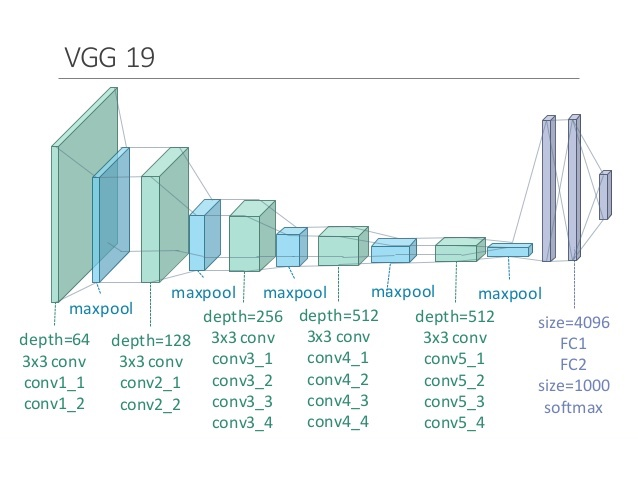

根据上图的VGG19网络结构，开始正式搭建VGG19模型，为了方便起见，先定义卷积层

In [5]:
# 定义卷积层，在VGGNet中，均使用3x3的卷积核
def conv3x3(in_features, out_features): 
    return nn.Conv2d(in_features, out_features, kernel_size=3, padding=1)

In [6]:
# 搭建VGG19，除了卷积层外，还包括2个全连接层（fc_1、fc_2），1个softmax层
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.features = nn.Sequential(
            # 1.con1_1
            conv3x3(3, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # 2.con1_2
            conv3x3(64, 64),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 3.con2_1
            conv3x3(64, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # 4.con2_2
            conv3x3(128, 128),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 5.con3_1
            conv3x3(128, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 6.con3_2
            conv3x3(256, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 7.con3_3
            conv3x3(256, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # 8.con3_4
            conv3x3(256, 256),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 9.con4_1
            conv3x3(256, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # 10.con4_2
            conv3x3(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # 11.con4_3
            conv3x3(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # 12.con4_4
            conv3x3(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            # 13.con5_1
            conv3x3(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # 14.con5_2
            conv3x3(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # 15.con5_3
            conv3x3(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            # 16.con5_4
            conv3x3(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            )

        self.classifier = nn.Sequential(
            # 17.fc_1
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(),
            # 18.fc_2
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            # 19.softmax
            nn.Linear(4096, 10),  # 最后通过softmax层，输出10个类别
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

定义好VGG19网络之后，开始训练

In [7]:
vgg19 = VGG().to(device)
# 可以通过打印vgg19观察具体的网络结构
# print(vgg19) 

# 使用Adam进行优化处理
optimizer = torch.optim.Adam(vgg19.parameters(), lr=LR)
# scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[40], gamma=0.1)
learn_history = []
learn_history={'train_loss':[],'train_acc':[],'test_loss':[],'test_acc':[],'lr':[]}

In [8]:
optimizer = torch.optim.SGD(vgg19.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5)

In [9]:
print('开始训练VGG19……')

for epoch in range(nepochs):
    # 训练开始时间
    since = time.time()
    train_epoch(vgg19, loss_func, optimizer, train_dl)
    
    # 每训练5轮输出一次结果
#     if (epoch)%5 == 0:
    tr_loss, tr_acc = eval(vgg19, loss_func, train_dl)
    te_loss, te_acc = eval(vgg19, loss_func, test_dl)

    learn_history['train_loss'].append(tr_loss)
    learn_history['train_acc'].append(tr_acc)
    learn_history['test_loss'].append(te_loss)
    learn_history['test_acc'].append(te_acc)
    lr = optimizer.param_groups[0]['lr']
    learn_history['lr'].append(lr)
    scheduler.step(tr_loss)
    # 完成一批次训练的结束时间
    now = time.time()
#     print('[%3d/%d, %.0f seconds]|\t 训练误差: %.1e, 训练正确率: %.2f\t |\t 测试误差: %.1e, 测试正确率: %.2f'%(
#         epoch+1, nepochs, now-since, tr_loss, tr_acc, te_loss, te_acc))
    print('[%3d/%d, %.0f seconds]|\t loss: %f, accuaracy: %2.2f%%\t|\ttest_loss: %f, test_accuaracy: %2.2f%%\ttrain_lr:%.6f'%
          (epoch+1, nepochs, now-since, tr_loss, tr_acc, te_loss, te_acc,lr))

开始训练VGG19……
[  1/300, 181 seconds]|	 loss: 1.917389, accuaracy: 21.32%	|	test_loss: 1.879786, test_accuaracy: 22.18%	train_lr:0.100000
[  2/300, 138 seconds]|	 loss: 1.713323, accuaracy: 34.59%	|	test_loss: 1.701524, test_accuaracy: 35.29%	train_lr:0.100000
[  3/300, 135 seconds]|	 loss: 1.681801, accuaracy: 43.74%	|	test_loss: 1.682940, test_accuaracy: 44.31%	train_lr:0.100000
[  4/300, 136 seconds]|	 loss: 1.979587, accuaracy: 42.09%	|	test_loss: 2.185517, test_accuaracy: 40.09%	train_lr:0.100000
[  5/300, 167 seconds]|	 loss: 1.923654, accuaracy: 43.40%	|	test_loss: 2.013944, test_accuaracy: 42.82%	train_lr:0.100000
[  6/300, 139 seconds]|	 loss: 1.289473, accuaracy: 59.10%	|	test_loss: 1.454073, test_accuaracy: 56.47%	train_lr:0.100000
[  7/300, 136 seconds]|	 loss: 1.082555, accuaracy: 65.86%	|	test_loss: 1.157367, test_accuaracy: 64.70%	train_lr:0.100000
[  8/300, 139 seconds]|	 loss: 1.049041, accuaracy: 64.62%	|	test_loss: 1.056721, test_accuaracy: 65.44%	train_lr:0.100000
[  9

[ 68/300, 136 seconds]|	 loss: 0.204419, accuaracy: 93.36%	|	test_loss: 0.376107, test_accuaracy: 88.53%	train_lr:0.025000
[ 69/300, 135 seconds]|	 loss: 0.232826, accuaracy: 92.51%	|	test_loss: 0.424314, test_accuaracy: 87.92%	train_lr:0.025000
[ 70/300, 137 seconds]|	 loss: 0.220235, accuaracy: 92.97%	|	test_loss: 0.417730, test_accuaracy: 87.43%	train_lr:0.025000
[ 71/300, 134 seconds]|	 loss: 0.162757, accuaracy: 94.66%	|	test_loss: 0.355240, test_accuaracy: 88.75%	train_lr:0.025000
[ 72/300, 135 seconds]|	 loss: 0.179980, accuaracy: 94.10%	|	test_loss: 0.356426, test_accuaracy: 89.22%	train_lr:0.025000
[ 73/300, 133 seconds]|	 loss: 0.234660, accuaracy: 92.54%	|	test_loss: 0.435341, test_accuaracy: 87.67%	train_lr:0.025000
[ 74/300, 142 seconds]|	 loss: 0.172976, accuaracy: 94.63%	|	test_loss: 0.377133, test_accuaracy: 88.74%	train_lr:0.025000
[ 75/300, 133 seconds]|	 loss: 0.073474, accuaracy: 97.57%	|	test_loss: 0.308477, test_accuaracy: 91.07%	train_lr:0.012500
[ 76/300, 132 se

[135/300, 136 seconds]|	 loss: 0.002429, accuaracy: 99.94%	|	test_loss: 0.351733, test_accuaracy: 93.01%	train_lr:0.001563
[136/300, 135 seconds]|	 loss: 0.002117, accuaracy: 99.93%	|	test_loss: 0.365884, test_accuaracy: 92.85%	train_lr:0.001563
[137/300, 132 seconds]|	 loss: 0.002348, accuaracy: 99.94%	|	test_loss: 0.355018, test_accuaracy: 93.10%	train_lr:0.001563
[138/300, 136 seconds]|	 loss: 0.002066, accuaracy: 99.94%	|	test_loss: 0.352129, test_accuaracy: 93.11%	train_lr:0.001563
[139/300, 135 seconds]|	 loss: 0.001754, accuaracy: 99.96%	|	test_loss: 0.360247, test_accuaracy: 93.10%	train_lr:0.001563
[140/300, 134 seconds]|	 loss: 0.001885, accuaracy: 99.96%	|	test_loss: 0.348858, test_accuaracy: 93.08%	train_lr:0.001563
[141/300, 134 seconds]|	 loss: 0.001799, accuaracy: 99.96%	|	test_loss: 0.352018, test_accuaracy: 92.98%	train_lr:0.001563
[142/300, 133 seconds]|	 loss: 0.001710, accuaracy: 99.97%	|	test_loss: 0.358276, test_accuaracy: 93.09%	train_lr:0.001563
[143/300, 134 se

[202/300, 135 seconds]|	 loss: 0.000631, accuaracy: 99.99%	|	test_loss: 0.366907, test_accuaracy: 93.24%	train_lr:0.000391
[203/300, 134 seconds]|	 loss: 0.000487, accuaracy: 100.00%	|	test_loss: 0.369565, test_accuaracy: 93.23%	train_lr:0.000391
[204/300, 133 seconds]|	 loss: 0.000475, accuaracy: 100.00%	|	test_loss: 0.367540, test_accuaracy: 93.27%	train_lr:0.000391
[205/300, 133 seconds]|	 loss: 0.000563, accuaracy: 100.00%	|	test_loss: 0.366658, test_accuaracy: 93.31%	train_lr:0.000391
[206/300, 134 seconds]|	 loss: 0.000456, accuaracy: 100.00%	|	test_loss: 0.367306, test_accuaracy: 93.30%	train_lr:0.000391
[207/300, 134 seconds]|	 loss: 0.000473, accuaracy: 100.00%	|	test_loss: 0.366930, test_accuaracy: 93.30%	train_lr:0.000391
[208/300, 139 seconds]|	 loss: 0.000518, accuaracy: 100.00%	|	test_loss: 0.367189, test_accuaracy: 93.21%	train_lr:0.000391
[209/300, 134 seconds]|	 loss: 0.000579, accuaracy: 100.00%	|	test_loss: 0.364239, test_accuaracy: 93.14%	train_lr:0.000391
[210/300,

[269/300, 137 seconds]|	 loss: 0.000409, accuaracy: 100.00%	|	test_loss: 0.364475, test_accuaracy: 93.40%	train_lr:0.000049
[270/300, 132 seconds]|	 loss: 0.000416, accuaracy: 100.00%	|	test_loss: 0.365315, test_accuaracy: 93.43%	train_lr:0.000049
[271/300, 134 seconds]|	 loss: 0.000422, accuaracy: 100.00%	|	test_loss: 0.367457, test_accuaracy: 93.44%	train_lr:0.000024
[272/300, 135 seconds]|	 loss: 0.000428, accuaracy: 100.00%	|	test_loss: 0.363932, test_accuaracy: 93.40%	train_lr:0.000024
[273/300, 132 seconds]|	 loss: 0.000407, accuaracy: 100.00%	|	test_loss: 0.364555, test_accuaracy: 93.36%	train_lr:0.000024
[274/300, 135 seconds]|	 loss: 0.000412, accuaracy: 100.00%	|	test_loss: 0.364582, test_accuaracy: 93.41%	train_lr:0.000024
[275/300, 135 seconds]|	 loss: 0.000423, accuaracy: 100.00%	|	test_loss: 0.366274, test_accuaracy: 93.33%	train_lr:0.000024
[276/300, 134 seconds]|	 loss: 0.000436, accuaracy: 100.00%	|	test_loss: 0.368165, test_accuaracy: 93.45%	train_lr:0.000024
[277/300

根据输出的结果，我们可以很明显的看出，在训练轮次增加后，正确率有了明显的提高，训练完50轮后，测试集的正确率达到89.16%，如果我们进一步增加训练轮次，正确率应该还会更高。

In [10]:
# 保存
torch.save(vgg19, 'vgg19_best.pkl')

In [22]:
model = torch.load('vgg19_best.pkl')

In [23]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [11]:
import os
save_model = True
if save_model:
    state = {
        'net':vgg19.state_dict(),# 模型的参数
        'epoch':100
    }
    os.makedirs('checkpoint',exist_ok=True)
    torch.save(state,'./checkpoint/vgg19_100.ckpt')

# 可视化误差曲线，准确率曲线，学习率曲线

In [12]:
import matplotlib.pyplot as plt
def plot_history(history):
    """
    plot loss and acc history.
    :param history: train returned history object
    """
    epoch_list = range(1,len(history['train_loss'])+1)
    plt.plot(epoch_list, history['train_loss'])
    plt.plot(epoch_list, history['test_loss'])
    plt.xlabel('epoch')
    plt.ylabel('Loss value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, history['train_acc'])
    plt.plot(epoch_list, history['test_acc'])
    plt.xlabel('epoch')
    plt.ylabel('acc value')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(epoch_list, history['lr'])
    plt.xlabel('epoch')
    plt.ylabel('Train LR')
    plt.show()

In [13]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

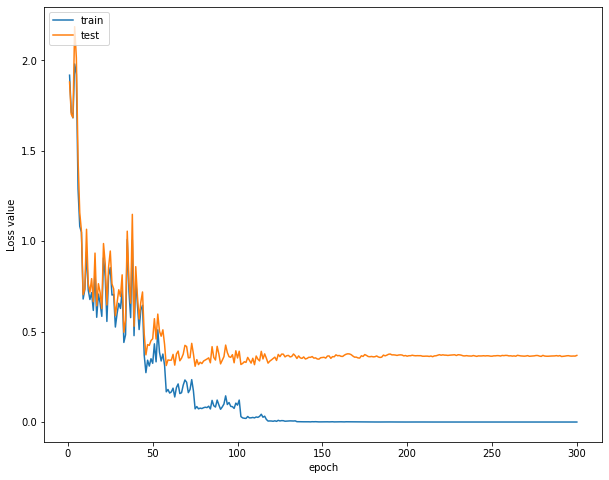

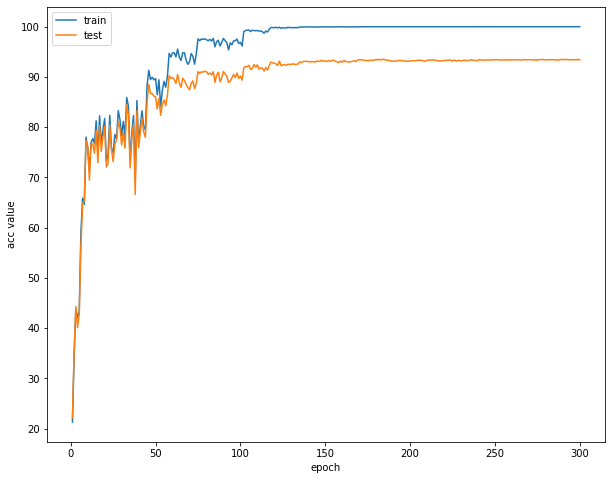

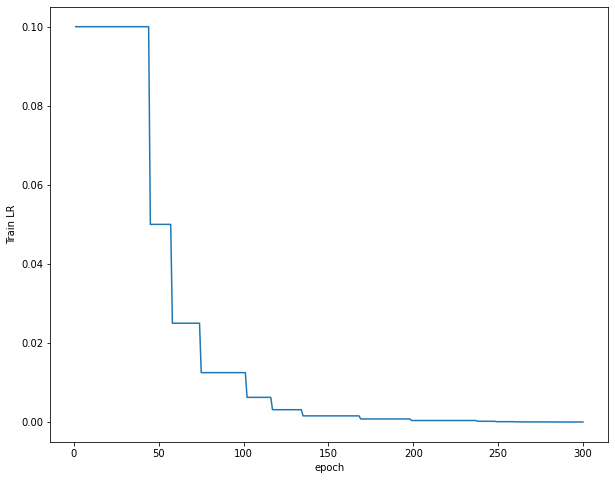

In [14]:
plot_history(learn_history)

In [15]:
f = open('history_vgg19_best.txt','a+')
f.write('new\n')
for i in range(len(learn_history['train_loss'])):
#     print( "%f %f %f %f"% (history['train_loss'][i],history['test_loss'][i],history['train_acc'][i],history['test_acc'][i]))
    f.writelines( "%f %f %f %f %f\n"% (learn_history['train_loss'][i],learn_history['test_loss'][i],learn_history['train_acc'][i],learn_history['test_acc'][i],learn_history['lr'][i]))
f.close()

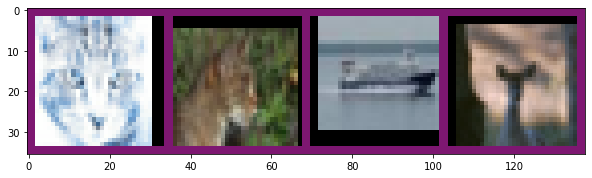

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    # normalizing
#     img = img / 2 + 0.5 # imgs are already noramlized during Transforming in data prepration
#     npimg = img.numpy()
    img = img.clone().detach().numpy().transpose(1, 2, 0)
    img = img * np.array(std) + np.array(mean)
    img = img.clip(0, 1)
#     print(img.shape)
    plt.imshow(img)
    # plt.show()

image_iter = iter(train_dl)
images, labels = image_iter.next()
imshow(torchvision.utils.make_grid(images[:4]))

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 93.37 %
Accuracy of plane : 86.21 %
Accuracy of   car : 100.00 %
Accuracy of  bird : 87.88 %
Accuracy of   cat : 82.35 %
Accuracy of  deer : 96.30 %
Accuracy of   dog : 90.91 %
Accuracy of  frog : 86.11 %
Accuracy of horse : 96.00 %
Accuracy of  ship : 100.00 %
Accuracy of truck : 97.44 %


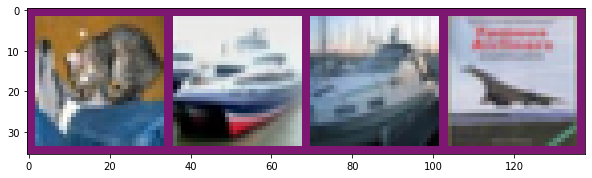

In [20]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')
dataiter = iter(test_dl)
images, labels = dataiter.next()
images = images[:4]
labels = labels[:4]
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


outputs = vgg19(images.to(device))
_, predicted = torch.max(outputs.cpu(), 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

correct = 0
total = 0
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg19(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %.2f %%' % 
      (100 * correct / total))


class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg19(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2.2f %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [21]:
print(mean)
print(std)

[0.4913725490196078, 0.09019607843137255, 0.4466666666666667]
[0.24705882352941178, 0.24352941176470588, 0.2615686274509804]
